In [1]:
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm import tqdm

## Configuration

In [2]:
# Chemins
PROJECT_ROOT = Path.cwd().parent
BASE_PATH = PROJECT_ROOT / "data" / "raw" / "COVID-19_Radiography_Dataset" / "COVID-19_Radiography_Dataset"
OUTPUT_PATH = PROJECT_ROOT / "data" / "processed" / "masked_dataset"

# Paramètres
TARGET_SIZE = (256, 256)
CLASSES = ["COVID", "Normal", "Lung_Opacity", "Viral Pneumonia"]

print(f"Dataset source: {BASE_PATH}")
print(f"Dataset de sortie: {OUTPUT_PATH}")
print(f"Taille cible: {TARGET_SIZE}")
print(f"Classes: {CLASSES}")

Dataset source: /home/cepa/DST/projet_DS/DS_COVID_ORGA/data/raw/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset
Dataset de sortie: /home/cepa/DST/projet_DS/DS_COVID_ORGA/data/processed/masked_dataset
Taille cible: (256, 256)
Classes: ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']


## Fonction de traitement

In [3]:
def process_and_save_image(image_path, mask_path, output_path):
    """
    Charge, resize, masque et sauvegarde une image.
    
    Args:
        image_path: Chemin de l'image source
        mask_path: Chemin du masque
        output_path: Chemin de sauvegarde
    """
    # 1. Charger et redimensionner l'image en grayscale
    img = Image.open(image_path).convert('L')
    img = img.resize(TARGET_SIZE, Image.Resampling.LANCZOS)
    img_arr = np.array(img)
    
    # 2. Charger et redimensionner le masque
    mask = Image.open(mask_path).convert('L')
    mask = mask.resize(TARGET_SIZE, Image.Resampling.NEAREST)
    mask_arr = (np.array(mask) / 255.0) > 0.5  # Binariser
    
    # 3. Appliquer le masque
    masked_img = img_arr * mask_arr
    
    # 4. Sauvegarder
    output_path.parent.mkdir(parents=True, exist_ok=True)
    Image.fromarray(masked_img.astype(np.uint8)).save(output_path)

## Traitement du dataset complet

In [4]:
# Statistiques
total_processed = 0
errors = []

# Traiter chaque classe
for class_name in CLASSES:
    print(f"\n{'='*60}")
    print(f"Traitement de la classe: {class_name}")
    print(f"{'='*60}")
    
    # Chemins source
    images_dir = BASE_PATH / class_name / "images"
    masks_dir = BASE_PATH / class_name / "masks"
    
    # Chemin de sortie
    output_dir = OUTPUT_PATH / class_name
    
    # Lister toutes les images
    image_files = sorted(images_dir.glob("*.png"))
    print(f"Nombre d'images trouvées: {len(image_files)}")
    
    # Traiter chaque image
    for img_path in tqdm(image_files, desc=f"Processing {class_name}"):
        try:
            # Trouver le masque correspondant
            mask_path = masks_dir / img_path.name
            
            if not mask_path.exists():
                errors.append((img_path, f"Masque introuvable: {mask_path}"))
                continue
            
            # Chemin de sortie
            output_file = output_dir / img_path.name
            
            # Traiter et sauvegarder
            process_and_save_image(img_path, mask_path, output_file)
            total_processed += 1
            
        except Exception as e:
            errors.append((img_path, str(e)))
    
    print(f"✓ {class_name}: {len(list(output_dir.glob('*.png')))} images créées")

print(f"\n{'='*60}")
print(f"RÉSUMÉ")
print(f"{'='*60}")
print(f"Total d'images traitées: {total_processed}")
print(f"Erreurs: {len(errors)}")

if errors:
    print("\nPremières erreurs:")
    for img, err in errors[:5]:
        print(f"  - {img.name}: {err}")


Traitement de la classe: COVID
Nombre d'images trouvées: 3616


Processing COVID: 100%|██████████| 3616/3616 [00:19<00:00, 189.12it/s]


✓ COVID: 3616 images créées

Traitement de la classe: Normal
Nombre d'images trouvées: 10192


Processing Normal: 100%|██████████| 10192/10192 [00:51<00:00, 196.30it/s]


✓ Normal: 10192 images créées

Traitement de la classe: Lung_Opacity
Nombre d'images trouvées: 6012


Processing Lung_Opacity: 100%|██████████| 6012/6012 [00:29<00:00, 206.98it/s]


✓ Lung_Opacity: 6012 images créées

Traitement de la classe: Viral Pneumonia
Nombre d'images trouvées: 1345


Processing Viral Pneumonia: 100%|██████████| 1345/1345 [00:06<00:00, 201.88it/s]

✓ Viral Pneumonia: 1345 images créées

RÉSUMÉ
Total d'images traitées: 21165
Erreurs: 0


## Vérification du dataset créé

Nombre d'images par classe dans le nouveau dataset:
  COVID: 3616
  Normal: 10192
  Lung_Opacity: 6012
  Viral Pneumonia: 1345


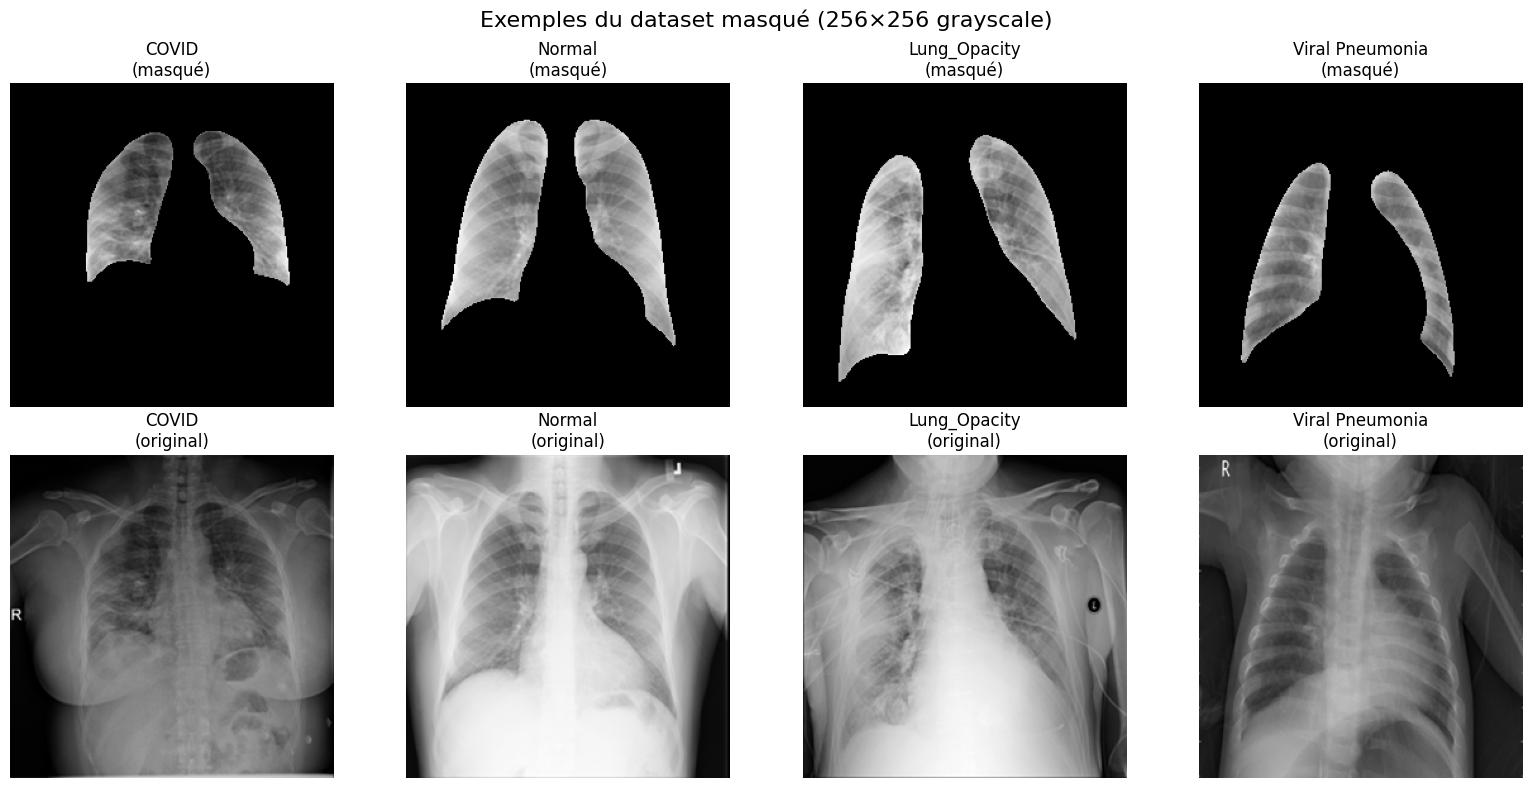


✓ Dataset masqué créé avec succès dans: /home/cepa/DST/projet_DS/DS_COVID_ORGA/data/processed/masked_dataset


In [5]:
import matplotlib.pyplot as plt

# Compter les images par classe
print("Nombre d'images par classe dans le nouveau dataset:")
for class_name in CLASSES:
    class_dir = OUTPUT_PATH / class_name
    n_images = len(list(class_dir.glob("*.png")))
    print(f"  {class_name}: {n_images}")

# Visualiser quelques exemples
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Exemples du dataset masqué (256×256 grayscale)", fontsize=16)

for idx, class_name in enumerate(CLASSES):
    class_dir = OUTPUT_PATH / class_name
    sample_img = next(class_dir.glob("*.png"))
    
    # Image masquée
    masked = Image.open(sample_img)
    axes[0, idx].imshow(masked, cmap='gray')
    axes[0, idx].set_title(f"{class_name}\n(masqué)")
    axes[0, idx].axis('off')
    
    # Image originale pour comparaison
    orig_img = BASE_PATH / class_name / "images" / sample_img.name
    original = Image.open(orig_img).convert('L').resize(TARGET_SIZE, Image.Resampling.LANCZOS)
    axes[1, idx].imshow(original, cmap='gray')
    axes[1, idx].set_title(f"{class_name}\n(original)")
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Dataset masqué créé avec succès dans: {OUTPUT_PATH}")

## Utilisation du nouveau dataset

Maintenant, pour utiliser ce dataset, c'est ultra-simple :

```python
from pathlib import Path
from PIL import Image
import numpy as np

# Charger toutes les images masquées
dataset_path = Path("data/processed/masked_dataset")
classes = ["COVID", "Normal", "Lung_Opacity", "Viral Pneumonia"]

X = []
y = []

for class_idx, class_name in enumerate(classes):
    class_dir = dataset_path / class_name
    for img_path in class_dir.glob("*.png"):
        img = np.array(Image.open(img_path))
        X.append(img)
        y.append(class_idx)

X = np.array(X)
y = np.array(y)

print(f"Dataset chargé: {X.shape}")
# Plus besoin de transformers !
```